# Convolutional Neural Network applied to Transient Detection

In [1]:
import numpy as np
import gzip
import matplotlib.pyplot as plt
%matplotlib inline

Put data loader into a function, break up potentially into train/valid/test subsets...

In [2]:
def load_pkl_data(chunk_num, split_frac=(0.8, 0.9), verbose=False):
    fname = 'all_chunks/chunk_%d_5000.pkl.gz' % chunk_num
    pkl_data = np.load(gzip.GzipFile(fname, 'rb'), encoding='bytes')
    if False:
        print(pkl_data.keys())
        print(pkl_data[b'diff_images'].shape)
    
    N_data = pkl_data[b'diff_images'].shape[0]
    if False:
        print(N_data)
    X = np.array([pkl_data[b'temp_images'].reshape((N_data, 21, 21)), 
                 pkl_data[b'sci_images'].reshape((N_data, 21, 21)),
                 pkl_data[b'diff_images'].reshape((N_data, 21, 21)),
                 pkl_data[b'SNR_images'].reshape((N_data, 21, 21))])
    X = np.swapaxes(X, 0, 1)

    Y = np.array([np.logical_not(pkl_data[b'labels']), pkl_data[b'labels']]).transpose()
    if False:
        print(X.shape, Y.shape)
        
    N_train = int(N_data * split_frac[0])
    N_valid = 0
    if split_frac[0] < 1.0:
        N_valid = int(N_data * split_frac[1])
    N_test = 0
    if split_frac[1] < 1.0:
        N_test  = int(N_data * 1.0)

    X_train, Y_train = X[:N_train], Y[:N_train]
    X_valid = Y_valid = None
    if N_valid > 0:
        X_valid, Y_valid = X[N_train:N_valid], Y[N_train:N_valid]
    X_test = Y_test = None
    if N_test > 0:
        X_test, Y_test = X[N_valid:N_test], Y[N_valid:N_test]

    if verbose:
        print(np.mean(Y[:,0]), np.mean(Y[:,1]))
        print("Train: ", X_train.shape, Y_train.shape)
        if N_valid > 0:
            print("Valid: ", X_valid.shape, Y_valid.shape)
        if N_test > 0:
            print("Test: ", X_test.shape, Y_test.shape)
        
    return (X_train, Y_train), (X_valid, Y_valid), (X_test, Y_test)

In [3]:
(X_train, Y_train), (X_test, Y_test), _ = load_pkl_data(188, (0.9, 1.0), verbose=True)

0.5 0.5
Train:  (4527, 4, 21, 21) (4527, 2)
Valid:  (503, 4, 21, 21) (503, 2)


We create a Keras sequential model and compile it.

In [4]:
from IPython.display import SVG
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.utils.vis_utils import plot_model, model_to_dot

# set dimensions ordering (depth as index 1)
import keras
keras.backend.set_image_dim_ordering('th')

def make_model(compile=True, epochs=100, lrate=0.01, decay=None):
    model = Sequential()
    model.add(ZeroPadding2D((3, 3), input_shape = (4, 21, 21)))
    model.add(Convolution2D(32, (4, 4), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    if epochs <= 2:
        model.add(Dropout(0.1))
    model.add(Dense(64, activation='relu'))
    if epochs <= 2:
        model.add(Dropout(0.1))
    model.add(Dense(2, activation='softmax'))
    
    if compile:
        # model.compile(loss='mean_squared_error',
        #       optimizer='sgd', metrics=['accuracy'])

        # initiate RMSprop optimizer (OLD)
        #opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

        # Compile model
        #epochs = 25
        #lrate = 0.01
        if decay is None:
            if epochs > 2:
                decay = lrate/epochs
            else:
                decay = lrate/100.
        opt = keras.optimizers.SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)

        # Let's train the model using RMSprop
        model.compile(loss='mean_squared_error', #categorical_crossentropy',
                      optimizer=opt,
                      metrics=['accuracy'])

    return model

Using TensorFlow backend.


In [5]:
epochs = 25
model = make_model(epochs=25)

In [6]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 4, 27, 27)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 24, 24)        2080      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 32, 26, 26)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 24, 24)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 12, 12)        0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 32, 14, 14)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 12, 12)        18496     
__________

Now, we fit our model to the training data-set

In [107]:
def run_model(model, train, valid, epochs=25, batch_size=32, data_augmentation=True, 
              patience=5, **kwargs):
    X_train, Y_train = train
    X_valid, Y_valid = valid
    
    from keras.callbacks import EarlyStopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience)

    if not data_augmentation:
        if epochs > 2:
            print('Not using data augmentation.')
        histry = model.fit(X_train, Y_train, batch_size=batch_size, 
                  epochs=epochs, validation_data=(X_valid, Y_valid),
                  shuffle=True, callbacks=[early_stopping], **kwargs)
    else:
        if epochs > 2:
            print('Using real-time data augmentation.')
        from keras.preprocessing.image import ImageDataGenerator
        # This will do preprocessing and realtime data augmentation:
        datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=True)  # randomly flip images

        # Compute quantities required for feature-wise normalization
        # (std, mean, and principal components if ZCA whitening is applied).
        # datagen.fit(X_train)  # so not needed.

        # Fit the model on the batches generated by datagen.flow().
        histry = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size), 
                            epochs=epochs, validation_data=(X_valid, Y_valid),
                            steps_per_epoch=X_train.shape[0] // batch_size,
                            callbacks=[early_stopping], **kwargs) 
        
    return model, histry

In [64]:
def plot_misclassified(model, ypred, Y_test, nmax=10, only_plot_misclassified=True):
    ytest = Y_test[:, 1].astype(int)

    N_plot = nmax
    only_plot_wrong = only_plot_misclassified
    if not only_plot_wrong:
        plot_inds = range(N_plot)
    else:
        plot_inds = np.where(ypred != ytest)[0]
        print("Incorrectly classified: %d of %d" % (len(plot_inds), len(ypred)))
        if len(plot_inds) > N_plot:
            plot_inds = plot_inds[:N_plot]
    N_plot = len(plot_inds)

    plt.clf()
    fig, axes = plt.subplots(N_plot, 4, figsize=(4, N_plot*1.2),
                            subplot_kw={'xticks': [], 'yticks': []})
    i = 0
    for ind in plot_inds:
        axes.flat[4*i].imshow(X_test[ind][0], interpolation = "none")
        axes.flat[4*i + 1].imshow(X_test[ind][1], interpolation = "none")
        axes.flat[4*i + 2].imshow(X_test[ind][2], interpolation = "none")
        axes.flat[4*i + 3].imshow(X_test[ind][3], interpolation = "none")

        axes.flat[4*i + 3].set_title ("predicted pbb = " + str(np.round(ypred[ind], 2)) + 
                                      ", label = " + str(ytest[ind]))
        i += 1
    plt.show()

Now try fitting a large number of data in batches:

In [7]:
n_data = 100  # number of datasets to run
seed = 666
batch_size = 32
epochs = 1  # 10   # Probably want to stop around 25 but now we have auto-stopping

In [94]:
np.random.seed(seed)
model = make_model()

for iter in range(100:)
    for d in range(n_data):
        (X_train, Y_train), (X_valid, Y_valid), (X_test, Y_test) = load_pkl_data(d)
        _, history = run_model(model, (X_train, Y_train), (X_valid, Y_valid), 
                  data_augmentation=True, verbose=0)
        score = model.evaluate(X_test, Y_test, verbose=0)
        print('Iter %d, Dataset %d: Test loss = %f; Test accuracy = %f' % (iter, d, score[0], score[1]))
        if iter > 0 and iter % 10 == 0:
            model.save('models/CNN_HiTS_demo_big_%02d.hdf5' % iter)

Dataset 0: Test loss = 0.020522; Test accuracy = 0.977011
Dataset 1: Test loss = 0.021069; Test accuracy = 0.978261
Dataset 2: Test loss = 0.047351; Test accuracy = 0.952096
Dataset 3: Test loss = 0.016788; Test accuracy = 0.986193
Dataset 4: Test loss = 0.014735; Test accuracy = 0.984095
Dataset 5: Test loss = 0.025702; Test accuracy = 0.968992
Dataset 6: Test loss = 0.014422; Test accuracy = 0.982143
Dataset 7: Test loss = 0.035030; Test accuracy = 0.956436
Dataset 8: Test loss = 0.033313; Test accuracy = 0.962151
Dataset 9: Test loss = 0.017067; Test accuracy = 0.984032
Dataset 10: Test loss = 0.006057; Test accuracy = 0.992395
Dataset 11: Test loss = 0.015210; Test accuracy = 0.984586
Dataset 12: Test loss = 0.027590; Test accuracy = 0.968064
Dataset 13: Test loss = 0.026422; Test accuracy = 0.970120
Dataset 14: Test loss = 0.010145; Test accuracy = 0.990291
Dataset 15: Test loss = 0.015365; Test accuracy = 0.984000
Dataset 16: Test loss = 0.009928; Test accuracy = 0.988350
Dataset

In [95]:
model.save('models/CNN_HiTS_demo_big_FINAL.hdf5')

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test[:,1].astype(int), pred)
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('FPR'); plt.ylabel('TPR (recall)')

Try using `fit_generator()` with a data generator.

In [8]:
from keras.preprocessing.image import ImageDataGenerator

# This will do preprocessing and realtime data augmentation:
imageDatagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True)  # randomly flip images

In [9]:
chunk = 3
(X, Y), _, _ = load_pkl_data(chunk, split_frac=(1.0, 1.0), verbose=False)
print(X.shape, Y.shape)

tmp = imageDatagen.flow(X, Y, batch_size=32).next()
tmp[0].shape

(5062, 4, 21, 21) (5062, 2)


(32, 4, 21, 21)

In [31]:
batch_size = 32

def data_generator_train():
    data_range = np.arange(150)  # use inds 0-150 for training
    while True:
        chunk = np.random.choice(data_range, size=1)[0]
        print('TRAIN:', chunk)
        (X, Y), _, _ = load_pkl_data(chunk, split_frac=(1.0, 1.0), verbose=False)
        for i in range(X.shape[0]//batch_size):  # about 5000/32 = 150
            Xb, Yb = imageDatagen.flow(X, Y, batch_size=batch_size).next()
            yield (Xb, Yb)

def data_generator_valid():
    data_range = np.arange(151, 235)  # use inds 151-234 for validation
    while True:
        chunk = np.random.choice(data_range, size=1)[0]
        print('VALID:', chunk)
        (X, Y), _, _ = load_pkl_data(chunk, split_frac=(1.0, 1.0), verbose=False)
        for i in range(X.shape[0]//batch_size): # about 5000/32 = 150
            Xb, Yb = imageDatagen.flow(X, Y, batch_size=batch_size).next()
            yield (Xb, Yb)
        
# Then we can use inds 235-284 as test data.
def data_generator_test():
    data_range = np.arange(235, 285)  # use inds 235-284 for test
    while True:
        chunk = np.random.choice(data_range, size=1)[0]
        print('TEST:', chunk)
        (X, Y), _, _ = load_pkl_data(chunk, split_frac=(1.0, 1.0), verbose=False)
        for i in range(X.shape[0]//batch_size): # about 5000/32 = 150
            Xb, Yb = imageDatagen.flow(X, Y, batch_size=batch_size).next()
            yield (Xb, Yb)

In [29]:
epochs = 10000

model = make_model(compile=True, epochs=epochs, lrate=0.01, decay=None)

train_generator = data_generator_train()
valid_generator = data_generator_valid()

from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=1000)
checkpointing = ModelCheckpoint('./best_model.hdf5', monitor='val_loss', verbose=1, 
                                save_best_only=True, save_weights_only=False, 
                                mode='auto', period=1)

model.fit_generator(generator=train_generator, 
                    validation_data = valid_generator, validation_steps=1,
                    #datagen.flow(X_train, Y_train, batch_size=batch_size), 
                    epochs=epochs, steps_per_epoch=100,
                    callbacks=[early_stopping, checkpointing], workers=1)

TRAIN:Epoch 1/10000 
86
 99/100 [============================>.] - ETA: 0s - loss: 0.0741 - acc: 0.9097VALID: 190
Epoch 00000: val_loss improved from inf to 0.03313, saving model to ./best_model.hdf5
100/100 [==============================] - 26s - loss: 0.0734 - acc: 0.9106 - val_loss: 0.0331 - val_acc: 0.9688
Epoch 2/10000
100/100 [==============================] - 26s - loss: 0.0301 - acc: 0.9659 - val_loss: 0.0901 - val_acc: 0.9062
Epoch 3/10000
100/100 [==============================] - 27s - loss: 0.0494 - acc: 0.9484 - val_loss: 0.0321 - val_acc: 0.9688
Epoch 4/10000
100/100 [==============================] - 27s - loss: 0.0320 - acc: 0.9637 - val_loss: 0.0313 - val_acc: 0.9688
Epoch 5/10000
100/100 [==============================] - 30s - loss: 0.0248 - acc: 0.9725 - val_loss: 0.0342 - val_acc: 0.9688
Epoch 6/10000
100/100 [==============================] - 25s - loss: 0.0178 - acc: 0.9816 - val_loss: 0.0084 - val_acc: 1.0000
Epoch 7/10000
100/100 [=============================

100/100 [==============================] - 26s - loss: 0.0235 - acc: 0.9734 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 27/10000
100/100 [==============================] - 24s - loss: 0.0188 - acc: 0.9800 - val_loss: 4.2166e-04 - val_acc: 1.0000
Epoch 28/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0254 - acc: 0.9694VALID: 212
Epoch 00027: val_loss did not improve
100/100 [==============================] - 25s - loss: 0.0255 - acc: 0.9694 - val_loss: 0.0084 - val_acc: 1.0000
Epoch 29/10000
100/100 [==============================] - 27s - loss: 0.0240 - acc: 0.9722 - val_loss: 0.0219 - val_acc: 0.9688
Epoch 30/10000
100/100 [==============================] - 24s - loss: 0.0230 - acc: 0.9734 - val_loss: 0.0352 - val_acc: 0.9688
Epoch 31/10000
100/100 [==============================] - 26s - loss: 0.0196 - acc: 0.9778 - val_loss: 0.0646 - val_acc: 0.9375
Epoch 32/10000
100/100 [==============================] - 24s - loss: 0.0209 - acc: 0.9778 - val_loss: 7.0159e-05 -

100/100 [==============================] - 28s - loss: 0.0120 - acc: 0.9872 - val_loss: 2.8946e-06 - val_acc: 1.0000
Epoch 54/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0137 - acc: 0.9845VALID: 168
Epoch 00053: val_loss did not improve
100/100 [==============================] - 30s - loss: 0.0136 - acc: 0.9844 - val_loss: 0.0313 - val_acc: 0.9688
Epoch 55/10000
100/100 [==============================] - 23s - loss: 0.0123 - acc: 0.9841 - val_loss: 2.5145e-05 - val_acc: 1.0000
Epoch 56/10000
100/100 [==============================] - 23s - loss: 0.0094 - acc: 0.9900 - val_loss: 0.0026 - val_acc: 1.0000
Epoch 57/10000
100/100 [==============================] - 25s - loss: 0.0159 - acc: 0.9834 - val_loss: 5.5672e-06 - val_acc: 1.0000
Epoch 58/10000
100/100 [==============================] - 22s - loss: 0.0163 - acc: 0.9819 - val_loss: 5.7957e-04 - val_acc: 1.0000
Epoch 59/10000
100/100 [==============================] - 24s - loss: 0.0183 - acc: 0.9788 - val_loss: 

100/100 [==============================] - 24s - loss: 0.0145 - acc: 0.9831 - val_loss: 3.1275e-05 - val_acc: 1.0000
Epoch 80/10000
100/100 [==============================] - 23s - loss: 0.0186 - acc: 0.9784 - val_loss: 1.6591e-04 - val_acc: 1.0000
Epoch 81/10000
100/100 [==============================] - 29s - loss: 0.0160 - acc: 0.9822 - val_loss: 0.0671 - val_acc: 0.9375
Epoch 82/10000
100/100 [==============================] - 26s - loss: 0.0143 - acc: 0.9834 - val_loss: 0.0271 - val_acc: 0.9688
Epoch 83/10000
100/100 [==============================] - 27s - loss: 0.0155 - acc: 0.9825 - val_loss: 6.7646e-05 - val_acc: 1.0000
Epoch 84/10000
100/100 [==============================] - 25s - loss: 0.0126 - acc: 0.9859 - val_loss: 0.0200 - val_acc: 0.9688
Epoch 85/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0134 - acc: 0.9855VALID: 178
Epoch 00084: val_loss did not improve
100/100 [==============================] - 28s - loss: 0.0133 - acc: 0.9856 - val_loss: 0.01

100/100 [==============================] - 24s - loss: 0.0158 - acc: 0.9822 - val_loss: 1.6412e-06 - val_acc: 1.0000
Epoch 107/10000
100/100 [==============================] - 25s - loss: 0.0148 - acc: 0.9828 - val_loss: 0.0369 - val_acc: 0.9375
Epoch 108/10000
100/100 [==============================] - 24s - loss: 0.0113 - acc: 0.9878 - val_loss: 0.0353 - val_acc: 0.9688
Epoch 109/10000
100/100 [==============================] - 29s - loss: 0.0133 - acc: 0.9850 - val_loss: 0.0313 - val_acc: 0.9688
Epoch 110/10000
100/100 [==============================] - 25s - loss: 0.0143 - acc: 0.9850 - val_loss: 1.2981e-04 - val_acc: 1.0000
Epoch 111/10000
100/100 [==============================] - 26s - loss: 0.0134 - acc: 0.9844 - val_loss: 0.0304 - val_acc: 0.9688
Epoch 112/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0095 - acc: 0.9890VALID: 228
Epoch 00111: val_loss did not improve
100/100 [==============================] - 28s - loss: 0.0094 - acc: 0.9891 - val_loss: 4.

KeyboardInterrupt: 

In [34]:
test_generator = data_generator_test()
score = model.evaluate_generator(test_generator, steps=500)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

TEST: 270
TEST: 239
TEST: 258
TEST: 245
Test loss: 0.00991866988396
Test accuracy: 0.9885625


5120/5120 [==============================] - 16s    
             precision    recall  f1-score   support

          0       1.00      0.99      0.99      2560
          1       0.99      1.00      0.99      2560

avg / total       0.99      0.99      0.99      5120



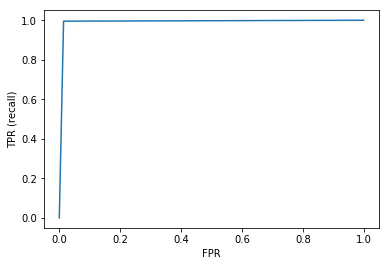

In [53]:
from sklearn import metrics

(X_test, Y_test), _, _ = load_pkl_data(235, split_frac=(1.0, 1.0), verbose=False)

pred = model.predict_classes(X_test)
print(metrics.classification_report(Y_test[:,1].astype(int), pred))

fpr, tpr, thresholds = metrics.roc_curve(Y_test[:,1].astype(int), pred)
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('FPR'); plt.ylabel('TPR (recall)')

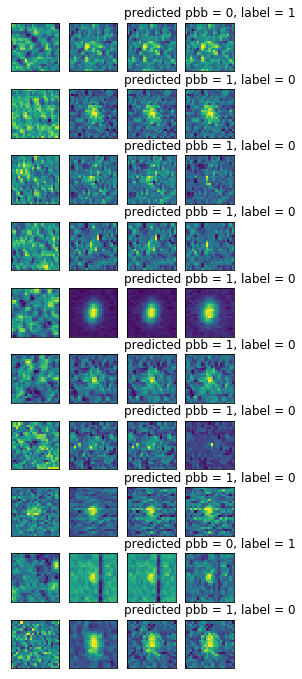

In [57]:
plot_misclassified(model, pred, Y_test, nmax=10, only_plot_misclassified=True)

Ran it for 10,000 iters on GPU box (it ran for 2,358 before stopping)...
here is the iter with the best `val_loss`:
```
Epoch 2333/10000
100/100 [==============================] - 2s - loss: 0.0067 - acc: 0.9919 - val_loss: 2.0465e-06 - val_acc: 1.0000e
```

In [60]:
model = keras.models.load_model('./best_model.hdf5')

In [61]:
test_generator = data_generator_test()
score = model.evaluate_generator(test_generator, steps=500)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

TEST: 239
TEST: 236
TEST: 251
TEST: 269
Test loss: 0.00978025480512
Test accuracy: 0.9894375


5120/5120 [==============================] - 16s    
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      2560
          1       0.99      0.99      0.99      2560

avg / total       0.99      0.99      0.99      5120



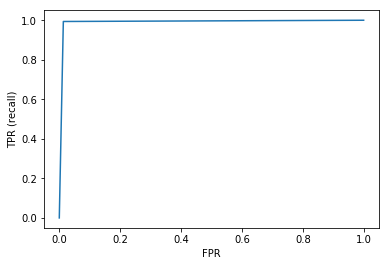

In [62]:
(X_test, Y_test), _, _ = load_pkl_data(235, split_frac=(1.0, 1.0), verbose=False)

pred = model.predict_classes(X_test)
print(metrics.classification_report(Y_test[:,1].astype(int), pred))

fpr, tpr, thresholds = metrics.roc_curve(Y_test[:,1].astype(int), pred)
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('FPR'); plt.ylabel('TPR (recall)')

Incorrectly classified: 50 of 5120


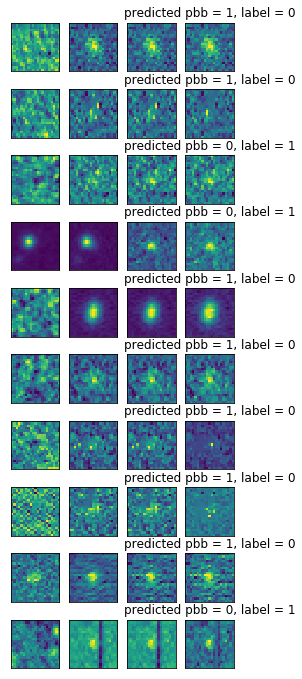

In [65]:
plot_misclassified(model, pred, Y_test, nmax=10, only_plot_misclassified=True)